## 感情分析モデル
<div style="font-size:1.2em; color:green; margin:20px">
    テキストの内容がネガティブ・ポジティブ・ニュートラルか判別します。<br>
    入力：英文テキスト<br>
    出力：感情分類
<div>

In [1]:
"""
必要なライブラリをインストール
 tesorflow 2.3.9
 numpy 1.20.1
 keras 2.4.3
"""
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
import os
import tensorflow as tf
from keras.preprocessing import text, sequence
import csv
import random
import pandas as pd

In [2]:
"""
データセット取得 
 kaggle Shanshank Yadav氏のPre-processed Twitter tweetsを使用させていただく。
 ラベルはNegative(0) Positive(2) Neutral(1)の３分類
 https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets

"""
x_datas = []
y_datas = []

# オリジナルのデータセットは分類ごとのCSVに分割されている
# 必要に応じてパスを変更する
neg_datas = pd.read_csv('../processedNegative.csv', engine="python")
for elem in neg_datas.columns:
    x_datas.append(elem.replace(".",""))
    y_datas.append(0)

neu_datas = pd.read_csv('../processedNeutral.csv', engine="python")
for elem in neu_datas.columns:
    x_datas.append(elem.replace(".",""))
    y_datas.append(1)

pos_datas = pd.read_csv('../processedPositive.csv', engine="python")
for elem in pos_datas.columns:
    x_datas.append(elem.replace(".",""))
    y_datas.append(2)
    
# データは結合されていることを確認
print(x_datas[0:10000:1000])
print(y_datas[0:10000:1000])


['How unhappy  some dogs like it though', 'Bells gone to daddies for to  days Work  work work for me unhappy ', ' firing underway', 'Enjoy happy']
[0, 0, 1, 2]


In [3]:
"""
データセットを訓練データとテストデータに分割（7:3）
"""
from sklearn.model_selection import train_test_split

# 訓練データ：テストデータを7:3に分割
X_train, X_test, Y_train, Y_test = train_test_split(
    x_datas, y_datas, 
    test_size=0.3, random_state=0
)


In [4]:
"""
テキストをトークン化する
String to INT
"""

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# テキストの最大長を取得
# 今回はLSTMの入力を固定長にするため
max_len = max(map(len, x_datas))

# トークン化
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

for text, vector in zip(X_train[0:3], x_train[0:3]):
    print(text)
    print(vector)
    
# 固定長ゼロパディング
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

print(x_train[0])
print(type(x_train))

Govt mulls giving power to award to teachers 
[82, 1194, 472, 836, 1, 1195, 1, 837]
Excited about event next week in Bangalore!  come happy
[673, 73, 674, 174, 79, 5, 1984, 255, 3]
Goodnight I love these beautiful boys unhappy  
[1196, 6, 51, 290, 329, 473, 2]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    

In [5]:
"""
正解データをone-hotベクトル化
"""
from keras.utils import np_utils

y_train = np.array(Y_train, dtype=int)
y_train = np_utils.to_categorical(y_train) 
y_test = np.array(Y_test, dtype=int)
y_test = np_utils.to_categorical(y_test) 

In [6]:
"""
学習モデルの構築
"""

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.optimizers import RMSprop

vocabulary_size = len(tokenizer.word_index) + 1  

model = Sequential()

model.add(Embedding(input_dim=vocabulary_size, output_dim=32))   # Embbedding層ではトークン化されたテキストをベクトル化する
model.add(LSTM(16, return_sequences=False, dropout=0.5))  #　すぐ過学習しがちなのでドロップアウトを入れる
model.add(Dense(3, activation='softmax'))   # ３値分類のためsoftmax関数を使用 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])   # RMSpropが学習しやすそう

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          170880    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 174,067
Trainable params: 174,067
Non-trainable params: 0
_________________________________________________________________


In [7]:

# 学習
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
85/85 [==============================] - 4s 46ms/step - loss: 1.0054 - accuracy: 0.4983 - val_loss: 0.8717 - val_accuracy: 0.7358
Epoch 2/10
85/85 [==============================] - 4s 41ms/step - loss: 0.7081 - accuracy: 0.7857 - val_loss: 0.5897 - val_accuracy: 0.8503
Epoch 3/10
85/85 [==============================] - 3s 40ms/step - loss: 0.4766 - accuracy: 0.8731 - val_loss: 0.4271 - val_accuracy: 0.8623
Epoch 4/10
85/85 [==============================] - 3s 39ms/step - loss: 0.3293 - accuracy: 0.8997 - val_loss: 0.3370 - val_accuracy: 0.8847
Epoch 5/10
85/85 [==============================] - 3s 40ms/step - loss: 0.2494 - accuracy: 0.9163 - val_loss: 0.2981 - val_accuracy: 0.8898
Epoch 6/10
85/85 [==============================] - 4s 42ms/step - loss: 0.2065 - accuracy: 0.9273 - val_loss: 0.2943 - val_accuracy: 0.8924
Epoch 7/10
85/85 [==============================] - 4s 41ms/step - loss: 0.1740 - accuracy: 0.9343 - val_loss: 0.2732 - val_accuracy: 0.8924
Epoch 8/10
85

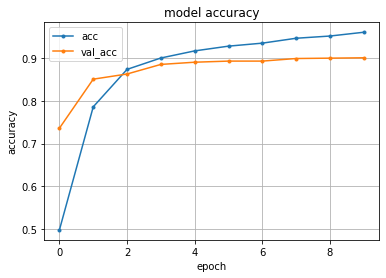

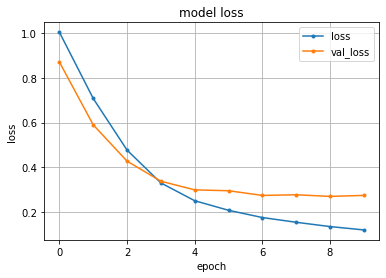

In [8]:
from matplotlib import pyplot as plt

# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [9]:
"""
不正解データを表示
P：予測値
A:正解値
"""
pre = model.predict(x_test)
print("P A text")
for i,v in enumerate(pre):
    pre_ans = v.argmax()
    ans = y_test[i].argmax()
    dat = X_test[i]
    if ans == pre_ans: continue
    print(pre_ans, ans, dat)

P A text
1 2 The one with backward cap
1 0 all ready for its poster - when my computer gets
1 0 WUUT SERIOUSLY? 
2 0 It seems they cost abut 40k a year? I'm paying half that for my full education and don't get treat 
1 2 we finally got jinyoung to wipe it for jaebum himself but their precious son blocks it for the world to witness it
1 2 Perfect
2 0 oh
1 0 Sorry for no stream yesterday
0 2 Okay
0 1 In stone-pelters miss Mehbooba's brother but he gets the message 
1 0 Note to self: Dont get to attached crying 
2 0 there are some rumors going around and videos of his performances on youtube have already been deleted 
2 0 Yeah 
2 0  never mind Khushi
2 1 In this part of UP
2 1 If you don't actually live then honesty and integrity won't be embraced
0 1 | I can understand the state ohf mind ohf ji right nohw Hence
1 0  but no sign
1 2  wifi
2 1  too hot
2 1 These will be ready long before winners are named 
2 0 We'd love to
0 2 you know what i really love about you lot?not only do you suppo

In [10]:
# 検証
# input_textに190文字以下の英文を入力する

input_text = ["It's good sunny today! "]
input_text = tokenizer.texts_to_sequences(input_text)
input_text = pad_sequences(input_text, maxlen=max_len)
pre = model.predict(input_text)
pre_ans = pre.argmax()
print(pre_ans)

2
